In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.7.0
GPU name: 


In [ ]:
import numpy as np

# Sequence modelling 

## Coding tutorials
 #### 1.  The IMDb dataset
 #### 2. Padding and masking sequence data
 #### 3. The `Embedding` layer
 #### 4. The Embedding Projector
 #### 5. Recurrent neural network layers
 #### 6. Stacked RNNs and the `Bidirectional` wrapper

***
<a id="coding_tutorial_1"></a>
## The IMDb Dataset

#### Load the IMDB review sentiment dataset

In [ ]:
# Import imdb

import tensorflow.keras.datasets.imdb as imdb

In [ ]:
# Download and assign the data set using load_data()

(x_train , y_train) , (x_test , y_test) = imdb.load_data()

#### Inspect the dataset

In [ ]:
# Inspect the type of the data

print(type(x_train))

<class 'numpy.ndarray'>


In [ ]:
# Inspect the shape of the data
  
print(x_train.shape) # เป็น ragged array ank 1 (row vector ทีแต่ละ element คือ list ของ encoding ขนาดไม่เท่ากัน) (each element is ragged numpy array)

(25000,)


In [ ]:
# Display the first dataset element input
# Notice encoding

print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [ ]:
# Display the first dataset element output

print(y_train[0]) # 1 = positive review

1


#### Load dataset with different options

Option ต่างๆเวลาโหลด dataset จาก imdb

In [ ]:
# Load the dataset with defaults

imdb.load_data(path = 'imdb.npz', # เปลี่ยนชื่อไฟล์และกำหนด path (defaultคือ  ~/.keras/dataset/)
              index_from = 3 # imdb จะ encode word ตามความถี่ที่ปรากฎ เช่น เจอมากสุด = 1 รองลงมา = 2
                            # เราให้่ index_from = 3 จะทำให้ word ที่เจอมากสุด = 1+3 = 4  รองลงมา = 2+3 = 5
                            # มีประโยชน์เวลา reserved index 0 1 2 ไว้ padding
              )

In [ ]:
# Limit the vocabulary to the top 500 words using num_words

imdb.load_data(num_words = 1000) # limit encoding 1000 คำแรกที่เจอบ่อยสุด

In [ ]:
# Ignore the top 10 most frequent words using skip_top

imdb.load_data(skip_top = 10 , num_words=1000 , oov_char = 2) # คำที่เจอบ่อยมากๆ อาจจะเป็น noise เช่น  a an the ให้ skip คำที่ top ตามที่ต้องการ
                                                              # คำที่ถูก skip , ไม่เอามาใช้จะเป็น oov (defaut เป็น integer 2)

In [ ]:
# Limit the sequence lengths to 500 using maxlen

imdb.load_data(maxlen=500) # จำกัดความยาว sequence

In [ ]:
 # Use '1' as the character that indicates the start of a sequence

 imdb.load_data(start_char = 1)  

#### Explore the dataset word index

เอาข้อมูลการ encode word มาใช้งาน

In [ ]:
# Load the imdb word index using get_word_index()

imdb_word_index = imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
# View the word index as a dictionary,
# accounting for index_from.

# อย่าลืมว่า frequency index มีการ + ด้วย index_from ตอน load data
# ใน orginal dataset เป็น index 1 2 3 ...
# นำมาทำเป็น dictionary ใหม่ตามที่เราโหลด dataมา

index_from = 3
imdb_word_index = {key: value + index_from for key,value in imdb_word_index.items()}

In [ ]:
# Retrieve a specific word's index

imdb_word_index['simpsonian']

52256

In [ ]:
imdb_word_index['the'] # word the เป็นคำที่เจอบ่อยสุด index 1+3

4

In [ ]:
# View an input sentence

inv_imdb_word_index = {value:key for key,value in imdb_word_index.items()} # สลับ key value เพื่อเอาไป decode ข้อความ ใช้ dictionary comprehension
[inv_imdb_word_index[index] for index in x_train[0] if index > index_from] # ต้องใส่เงื่อนไข index > index_from เพราะไม่เอา oov word

['this',
 'film',
 'was',
 'just',
 'brilliant',
 'casting',
 'location',
 'scenery',
 'story',
 'direction',
 "everyone's",
 'really',
 'suited',
 'the',
 'part',
 'they',
 'played',
 'and',
 'you',
 'could',
 'just',
 'imagine',
 'being',
 'there',
 'robert',
 "redford's",
 'is',
 'an',
 'amazing',
 'actor',
 'and',
 'now',
 'the',
 'same',
 'being',
 'director',
 "norman's",
 'father',
 'came',
 'from',
 'the',
 'same',
 'scottish',
 'island',
 'as',
 'myself',
 'so',
 'i',
 'loved',
 'the',
 'fact',
 'there',
 'was',
 'a',
 'real',
 'connection',
 'with',
 'this',
 'film',
 'the',
 'witty',
 'remarks',
 'throughout',
 'the',
 'film',
 'were',
 'great',
 'it',
 'was',
 'just',
 'brilliant',
 'so',
 'much',
 'that',
 'i',
 'bought',
 'the',
 'film',
 'as',
 'soon',
 'as',
 'it',
 'was',
 'released',
 'for',
 'retail',
 'and',
 'would',
 'recommend',
 'it',
 'to',
 'everyone',
 'to',
 'watch',
 'and',
 'the',
 'fly',
 'fishing',
 'was',
 'amazing',
 'really',
 'cried',
 'at',
 'the',


In [ ]:
# Get the sentiment value

y_train[0]

1

---
<a id="coding_tutorial_2"></a>
## Padding and Masking Sequence Data

In [ ]:
# Load the imdb data set

import tensorflow.keras.datasets.imdb as imdb
(x_train , y_train) , (x_test , y_test) = imdb.load_data()

#### Preprocess the data with padding

In [ ]:
# Inspect the input data shape

x_train.shape # เป็น ragged array (array ที่มีขนาดไม่เท่ากัน) เพราเป็น sequen data จึงต้องเก็บเป็น list ในแต่ละ element
              # เอาไปใช้งานไม่ได้เพราะเป็น rank 1  แต่ละ element เป็น list ขนาดไม่เท่ากัน

(25000,)

In [ ]:
# Pad the inputs to the maximum length using maxlen
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_x_train = pad_sequences(x_train , maxlen = 300, padding= 'post' , truncating='pre')

In [ ]:
# Inspect the output data shape

# คราวนี้จะเป็น rank 2 array ได้แล้วเพราะ shape ทุก element เท่ากัน 
print(padded_x_train.shape)
print(type(padded_x_train))
print(padded_x_train[0])

(25000, 300)
<class 'numpy.ndarray'>
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    46     7
     4 12118  

#### Create a Masking layer

เวลาจะเอาไปใช้งาน เราจะไม่สนใจ pad value จึงต้องสร้าง masking layer เอาไว้ skip ค่าที่ไม่ต้องการ masking layer จะรับ input เป็น rank 3 tensor <br> 
( sample , sequence element , features) <br> ฟีเจอร์มี dimension > 1 ได้


In [ ]:
# Import numpy 

import numpy as np

In [ ]:
# Masking expects to see (batch, sequence, features)
# Create a dummy feature dimension using expand_dims

padded_x_train = np.expand_dims(padded_x_train,-1) # เพิ่ม last axis
# หรือทำแบบนี้ก็ได้ padded_x_train = [..., np.newaxis]
print(padded_x_train.shape)

(25000, 300, 1)


In [ ]:
# Create a Masking layer 

from tensorflow.keras.layers import Masking

# แปลงเป็น จาก numpy เป็น tensor object
tf_x_train = tf.convert_to_tensor(padded_x_train,dtype='float32')

# สร้าง masking layer instance
masking_layer = Masking(mask_value = 0.0) # ให้ layer รู้ว่า ค่า 0 = padding (ต้องตรงกับที่เรา pad)

In [ ]:
# Pass tf_x_train to it

# Functional API pass tensor ไปยัง layer และ output tensor ที่ผ่านการ mask
mask_x_train = masking_layer(tf_x_train)

In [ ]:
# Look at the dataset

print(tf_x_train)
print(mask_x_train)

tf.Tensor(
[[[1.000e+00]
  [1.400e+01]
  [2.200e+01]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[1.000e+00]
  [1.940e+02]
  [1.153e+03]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[1.000e+00]
  [1.400e+01]
  [4.700e+01]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 ...

 [[1.000e+00]
  [1.100e+01]
  [6.000e+00]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[1.000e+00]
  [1.446e+03]
  [7.079e+03]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[1.000e+00]
  [1.700e+01]
  [6.000e+00]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]], shape=(25000, 300, 1), dtype=float32)
tf.Tensor(
[[[1.000e+00]
  [1.400e+01]
  [2.200e+01]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[1.000e+00]
  [1.940e+02]
  [1.153e+03]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[1.000e+00]
  [1.400e+01]
  [4.700e+01]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 ...

 [[1.000e+00]
  [1.100e+01]
  [6.000e+00]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[1.00

In [ ]:
# Look at the ._keras_mask for the dataset

#  ._keras_mask  เอาไว้ filter padding value เวลา train
mask_x_train._keras_mask 

<tf.Tensor: shape=(25000, 300), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

***
<a id="coding_tutorial_3"></a>
## The Embedding layer

Embedding layer จะอยู่ต้นโมเดลเพื่อ map จาก token ไปเป็น feature word embedding

#### Create and apply an `Embedding` layer

In [ ]:
# Create an embedding layer using layers.Embedding
# Specify input_dim, output_dim, input_length

from tensorflow.keras.layers import Embedding

# input_dim คือ vocab size 501 คือ 0-500
# output_dim คือ dimension embedding vector
# หลังสร้างจะ random initialize feature vector
embedding_layer = Embedding(input_dim = 501 , output_dim = 16)

In [ ]:
# Inspect an Embedding layer output for a fixed input
# Expects an input of shape (batch, sequence, feature)

sequence_of_indice = tf.constant([[[0],[1],[5],[500]]]) # แรนดอม input
print(sequence_of_indice) # rank 3 (batch, sequence, feature)
sequence_of_embeddeing = embedding_layer(sequence_of_indice)
print(sequence_of_embeddeing) # rank 4 (batch, sequence, feature , word embedding)

tf.Tensor(
[[[  0]
  [  1]
  [  5]
  [500]]], shape=(1, 4, 1), dtype=int32)
tf.Tensor(
[[[[-0.00873854 -0.03011834 -0.01585035 -0.03252014 -0.04887017
     0.02121664 -0.03627095 -0.00487135 -0.00498138  0.01421663
    -0.04181988  0.03601768  0.03646833  0.02503916  0.0349548
     0.01567801]]

  [[-0.0238189   0.04458017 -0.00274252  0.04677941  0.0445394
    -0.03326239 -0.03541745 -0.00418784 -0.01899729 -0.04975349
    -0.02333542 -0.01043601  0.00100145  0.04045952 -0.02247224
    -0.00191437]]

  [[-0.04826615 -0.01157528 -0.03726422  0.02356834  0.03039778
    -0.04691541  0.01866036  0.00060824  0.03266087  0.03417352
     0.03791878  0.00473116 -0.02028628  0.04194424  0.04298006
    -0.02585765]]

  [[ 0.03122772  0.02257473  0.0321173  -0.04901312  0.02184906
     0.03877092 -0.00633891 -0.02634416 -0.03770753 -0.02661256
     0.02171154  0.01904771 -0.04695972 -0.04003983 -0.00199528
     0.03781172]]]], shape=(1, 4, 1, 16), dtype=float32)


In [ ]:
# Inspect the Embedding layer weights using get_weights()

print(embedding_layer.get_weights()[0])
print(len(embedding_layer.get_weights()[0])) # weight มี 501 ตัว

[[-0.00873854 -0.03011834 -0.01585035 ...  0.02503916  0.0349548
   0.01567801]
 [-0.0238189   0.04458017 -0.00274252 ...  0.04045952 -0.02247224
  -0.00191437]
 [-0.0477358   0.04931458  0.006604   ...  0.01894001 -0.03354265
  -0.00737697]
 ...
 [ 0.04173001  0.0418486  -0.0066959  ... -0.00539003 -0.01540781
  -0.00848002]
 [-0.04624204 -0.01006808 -0.01274152 ... -0.04964236  0.02162344
   0.0333777 ]
 [ 0.03122772  0.02257473  0.0321173  ... -0.04003983 -0.00199528
   0.03781172]]
501


In [ ]:
# Get the embedding for the 14th index

embedding_layer.get_weights()[0][14,:]

array([-0.04081489, -0.01460823, -0.01408944, -0.03357303, -0.04811006,
       -0.04803495,  0.01670292, -0.04743316, -0.04693985, -0.01180322,
        0.02475454,  0.02344329,  0.04242363, -0.00651626, -0.01327844,
       -0.04736875], dtype=float32)

#### Create and apply an `Embedding` layer that uses `mask_zero=True`

In [ ]:
# Create a layer that uses the mask_zero kwarg

mask_embedding_layer = Embedding(input_dim = 501 , output_dim = 16,mask_zero = True)

In [ ]:
# Apply this layer to the sequence and see the _keras_mask property

mask_sequence_of_embedding = mask_embedding_layer(sequence_of_indice)
mask_sequence_of_embedding._keras_mask

<tf.Tensor: shape=(1, 4, 1), dtype=bool, numpy=
array([[[False],
        [ True],
        [ True],
        [ True]]])>

---
<a id="coding_tutorial_4"></a>
## The Embedding Projector

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load and preprocess the IMDb data

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset()

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index

imdb_word_index = get_imdb_word_index() # เป็๋น dictionary ที่ key = word , value = index

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
# Swap the keys and values of the word index

# เอาไว้ decode (pass index จะได้ word ออกมา)
inv_imdb_word_index = {value: key for key, value in imdb_word_index.items()}

In [ ]:
# View the first dataset example sentence

sample = [inv_imdb_word_index[index] for index in x_train[100] if index > 2] # ไม่เอาpadding และ oov
print(sample)

['i', 'am', 'a', 'great', 'fan', 'of', 'david', 'lynch', 'and', 'have', 'everything', 'that', "he's", 'made', 'on', 'dvd', 'except', 'for', 'hotel', 'room', 'the', '2', 'hour', 'twin', 'peaks', 'movie', 'so', 'when', 'i', 'found', 'out', 'about', 'this', 'i', 'immediately', 'grabbed', 'it', 'and', 'and', 'what', 'is', 'this', "it's", 'a', 'bunch', 'of', 'drawn', 'black', 'and', 'white', 'cartoons', 'that', 'are', 'loud', 'and', 'foul', 'mouthed', 'and', 'unfunny', 'maybe', 'i', "don't", 'know', "what's", 'good', 'but', 'maybe', 'this', 'is', 'just', 'a', 'bunch', 'of', 'crap', 'that', 'was', 'on', 'the', 'public', 'under', 'the', 'name', 'of', 'david', 'lynch', 'to', 'make', 'a', 'few', 'bucks', 'too', 'let', 'me', 'make', 'it', 'clear', 'that', 'i', "didn't", 'care', 'about', 'the', 'foul', 'language', 'part', 'but', 'had', 'to', 'keep', 'the', 'sound', 'because', 'my', 'neighbors', 'might', 'have', 'all', 'in', 'all', 'this', 'is', 'a', 'highly', 'disappointing', 'release', 'and', 'm

#### Build an Embedding layer into a model

In [ ]:
# Get the maximum token value

# เพื่อเอาไปใช้ระบุจำนวน word (vocab_size)
max_index_value = max(imdb_word_index.values()) 
print(max_index_value)

10000


In [ ]:
# Specify an embedding dimension

embedding_dim = 16

In [ ]:
# Build a model using Sequential:
#     1. Embedding layer
#     2. GlobalAveragePooling1D
#     3. Dense

# สร้าง Vanila NN  ทำ sentiment analysis
# Embedding layer จะ map จาก token ที่เป็น interger เป็น  n-dimensional embedding vector และ ค่า weight ของ layer นี้จะ learnได้
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=False), # input_dim=max_index_value+1 คือมีศัพท์ 1000 คำ + 0 ที่เป็น padding (0-1000 = 1001 ตัว)
                             tf.keras.layers.GlobalAveragePooling1D(), # ไม่ได้ใช้ RNN เฉลี่ยembedding vector ของทุก timestep ในตำแหน่งเดียวกัน across time (time-wise average)
                             tf.keras.layers.Dense(1,activation='sigmoid')])

In [ ]:
# Functional API refresher: use the Model to build the same model

# input จริง จะเป็น (sample , sequnce length) keras omit  dimension sample เหลือ (sequnce length,)
review_input = tf.keras.Input((None, )) # ที่เป็น (None,) เพราะ sequnce length ความยาวเท่าไหร่ก็ได่ (ให้แทนด้วย None)
embeddening_sequence = tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=False)(review_input)
average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embeddening_sequence)
positive_propability = tf.keras.layers.Dense(1,activation='sigmoid')(average_embedding)

model = tf.keras.Model(inputs = review_input , outputs = positive_propability)

In [ ]:
model.summary() # 160016  param มาจาก 10001 token * 16 feture dimension

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


#### Compile, train, and evaluate the model

In [ ]:
# Compile the model with a binary cross-entropy loss

model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Train the model using .fit(), savng its history

history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), validation_steps=20)

Epoch 1/5
782/782 [==============================] - 10s 10ms/step - loss: 0.6895 - accuracy: 0.5706 - val_loss: 0.6807 - val_accuracy: 0.6750
Epoch 2/5
782/782 [==============================] - 8s 10ms/step - loss: 0.6643 - accuracy: 0.6786 - val_loss: 0.6398 - val_accuracy: 0.7437
Epoch 3/5
782/782 [==============================] - 8s 10ms/step - loss: 0.6151 - accuracy: 0.7672 - val_loss: 0.5869 - val_accuracy: 0.7734
Epoch 4/5
782/782 [==============================] - 8s 10ms/step - loss: 0.5610 - accuracy: 0.8038 - val_loss: 0.5367 - val_accuracy: 0.7859
Epoch 5/5
782/782 [==============================] - 8s 10ms/step - loss: 0.5113 - accuracy: 0.8280 - val_loss: 0.4931 - val_accuracy: 0.8062


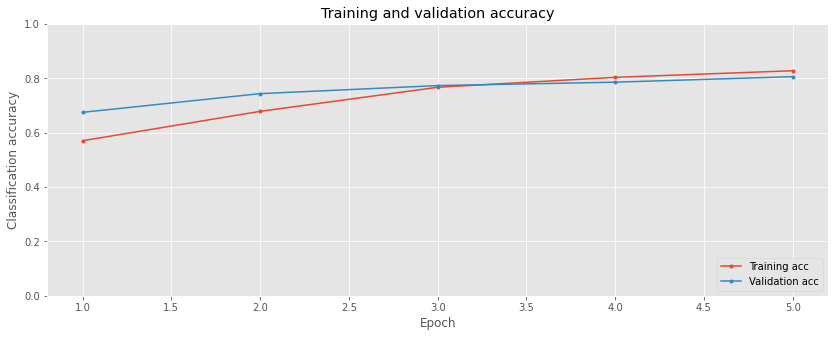

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### The TensorFlow embedding projector

The Tensorflow embedding projector can be found [here](https://projector.tensorflow.org/).

In [ ]:
# Retrieve the embedding layer's weights from the trained model

# layer[1] = embedding_1 (Embedding)     
weights = model.layers[1].get_weights()[0] 

In [ ]:
# Save the word Embeddings to tsv files
# Two files: 
#     one contains the embedding labels (meta.tsv),
#     one contains the embeddings (vecs.tsv)

import io
from os import path

#out_v = io.open(path.join('data', 'vecs.tsv'), 'w', encoding='utf-8')
out_v = io.open('/content/drive/MyDrive/Tensorflow for deep learning Specialization/Course 2/Week3/vecs.tsv', 'w', encoding='utf-8')
#out_m = io.open(path.join('data', 'meta.tsv'), 'w', encoding='utf-8')
out_m = io.open('/content/drive/MyDrive/Tensorflow for deep learning Specialization/Course 2/Week3/meta.tsv', 'w', encoding='utf-8')
k = 0

for word, token in imdb_word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!

---
<a id="coding_tutorial_5"></a>
## Recurrent neural network layers

#### Initialize and pass an input to a SimpleRNN layer

In [ ]:
# Create a SimpleRNN layer and test it

simplernn_layer = tf.keras.layers.SimpleRNN(units=16) #กำหนดแค่ neuron unit ในแต่ step จำนวน step จะสร้างเองตาม input length

In [ ]:
# Note that only the final cell output is returned

sequence  = tf.constant([[[1.,1.],[2.,2.],[56.,-100]]]) # dummy sequence เอาไว้เทส
layer_output = simplernn_layer(sequence)
print(layer_output) # ค่า deafault output ออกมาแค่ step สุดท้าย

tf.Tensor(
[[-1.        -1.         1.         1.         1.        -1.
   1.         1.         1.        -1.        -1.         1.
   1.        -1.        -1.         0.3672385]], shape=(1, 16), dtype=float32)


#### Load and transform the IMDB review sentiment dataset

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset


(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset(maxlen=250)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index()

1654784/1641221 [==============================] - 0s 0us/step


#### Create a recurrent neural network model

In [ ]:
# Get the maximum index value

max_index_value = max(imdb_word_index.values())
embedding_dim = 16

In [ ]:
# Using Sequential, build the model:
# 1. Embedding.
# 2. LSTM.
# 3. Dense.

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim = max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             tf.keras.layers.LSTM(units=16),
                             tf.keras.layers.Dense(units = 1 ,activation ='sigmoid')])

#### Compile and fit the model

In [ ]:
# Compile the model with binary cross-entropy loss

model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Fit the model and save its training history

history = model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
536/536 [==============================] - 452s 844ms/step - loss: 0.4119 - accuracy: 0.8206
Epoch 2/3
536/536 [==============================] - 449s 838ms/step - loss: 0.2311 - accuracy: 0.9154
Epoch 3/3
536/536 [==============================] - 447s 834ms/step - loss: 0.1693 - accuracy: 0.9401


#### Plot learning curves

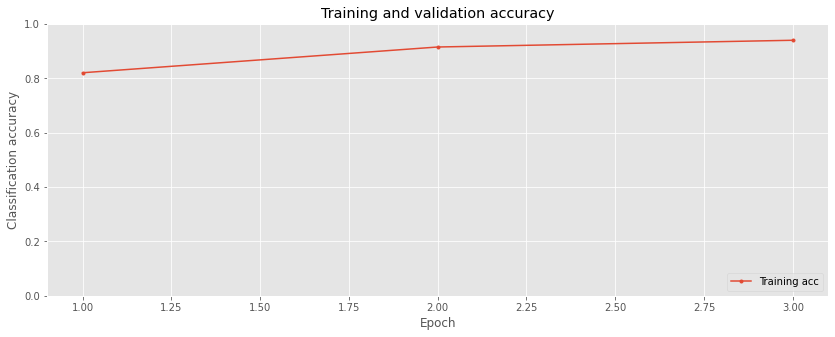

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
#val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
#val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
#plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### Make predictions with the model

In [ ]:
# View the first test data example sentence
# (invert the word index)

# decode ออกมาดูก่อน
inv_imdb_word_index = {value: key for key, value in imdb_word_index.items()}
sample = [inv_imdb_word_index[index] for index in x_train[0] if index > 2] # ไม่เอาpadding และ oov
print(sample)

['this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you', 'could', 'just', 'imagine', 'being', 'there', 'robert', 'is', 'an', 'amazing', 'actor', 'and', 'now', 'the', 'same', 'being', 'director', 'father', 'came', 'from', 'the', 'same', 'scottish', 'island', 'as', 'myself', 'so', 'i', 'loved', 'the', 'fact', 'there', 'was', 'a', 'real', 'connection', 'with', 'this', 'film', 'the', 'witty', 'remarks', 'throughout', 'the', 'film', 'were', 'great', 'it', 'was', 'just', 'brilliant', 'so', 'much', 'that', 'i', 'bought', 'the', 'film', 'as', 'soon', 'as', 'it', 'was', 'released', 'for', 'and', 'would', 'recommend', 'it', 'to', 'everyone', 'to', 'watch', 'and', 'the', 'fly', 'fishing', 'was', 'amazing', 'really', 'cried', 'at', 'the', 'end', 'it', 'was', 'so', 'sad', 'and', 'you', 'know', 'what', 'they', 'say', 'if', 'you', 'cry', 'at', 'a', 'film', 'it', 'must', 'have',

In [ ]:
# Get the model prediction using model.predict()

model.predict(x_test[None,0,:]) # x_test[None,0,:] คือ x_test example แรก แต่ จะได้ ออกมาเป็นrank 2
                                # ตัวโมเดลรับ input เป็น rank 3 (อันแรกคือ batch size) ถึงแม้จะมี example เดียว แต่ก็ต้อง add dummy dimension

array([[0.07424659]], dtype=float32)

In [ ]:
# Get the corresponding label

y_test[0]

0

---
<a id="coding_tutorial_6"></a>
## Stacked RNNs and the Bidirectional wrapper

#### Load and transform the IMDb review sentiment dataset

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset(maxlen=250,num_words=5000)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index()

1654784/1641221 [==============================] - 0s 0us/step


#### Build stacked and bidirectional recurrent models

In [ ]:
# Get the maximum index value and specify an embedding dimension

max_index_value = max(imdb_word_index.values())
embedding_dim = 16

In [ ]:
# Using Sequential, build a stacked LSTM model via return_sequences=True

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim = max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             tf.keras.layers.LSTM(units=32 , return_sequences=True), # output ทุก sequence เพื่อ ไป feed เป็น input ไปยัง RNN อีก layer
                             tf.keras.layers.LSTM(units=32 , return_sequences=False), # output ที่ step สุดท้าย
                             tf.keras.layers.Dense(units = 1 ,activation ='sigmoid')])

In [ ]:
# Using Sequential, build a bidirectional RNN with merge_mode='sum'

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim = max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             # bidirectional RNN(LSTM) มี output ทั้งขาไปและขากลับของแต่ละ step
                             # เราต้องเลือก merge_mode ว่าจะรวม output ยังไง
                             # มี sum , mul , concat , ave
                             # ถึงจะ output ที่ step สุดท้ายแต่ก็มีทั้งขาไปและขากลับ ต้องรวมกัน
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=8), merge_mode='sum'),
                             tf.keras.layers.Dense(units = 1 ,activation ='sigmoid')])

In [ ]:
# build a bidirectional RNN with different layer forward and  backward
# ตัวอย่าง สร้าง model ที่ขาไปและขากลับ ใช้ RNN คนละชนิดได้
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim = max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             # ขาไป layer = ...
                             # ขากลับ backward_layer = ...
                             # layer ขากลับใช้ keyword argument go_backwards=True
                             tf.keras.layers.Bidirectional(layer = tf.keras.layers.LSTM(units=8) , backward_layer=tf.keras.layers.GRU(units=8, go_backwards=True), merge_mode='sum'),
                             tf.keras.layers.Dense(units = 1 ,activation ='sigmoid')])

In [ ]:
# Create a model featuring both stacked recurrent layers and a bidirectional layer

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim = max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=8, return_sequences=True), merge_mode='concat'),
                             tf.keras.layers.GRU(units=8,return_sequences=False),
                             tf.keras.layers.Dense(units = 1 ,activation ='sigmoid')])

#### Compile and fit the model

In [ ]:
# Compile the model

model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Train the model, saving its history

history = model.fit(x_train, y_train, epochs=3, batch_size=32)

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

NameError: ignored